dict_keys(['nepochs', 'lr_f', 'lr_g', 'epoch_size', 'datatype', 'f_per_g', 'g_per_f', 'burn_in', 'batch_size', 'loss_li_ratio', 'loss_wasser_ratio', 'grad_norm', 'learning_rate_scheduler'])
HEY$$$$$$$$


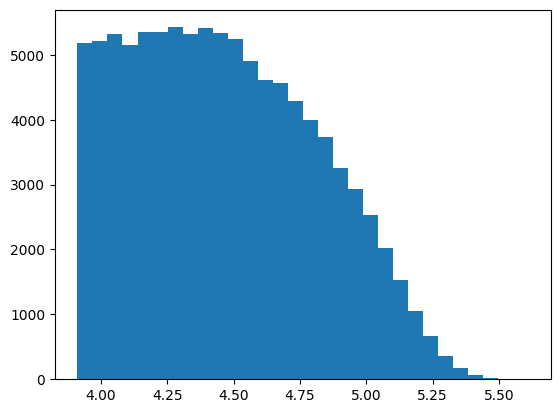

tensor([[4.7040, 0.4007],
        [4.7523, 0.0586],
        [4.3297, 0.2291],
        ...,
        [4.0119, 0.1766],
        [4.2444, 0.2306],
        [4.2327, 0.6481]], grad_fn=<IndexBackward0>)
(99000, 2)


In [40]:
"OT decorrelation"
import pyrootutils

#root = pyrootutils.setup_root(search_from=__file__, pythonpath=True)
root = '/Users/gretabrianti/Work/decorrelation_methods2/ot_decorrelation'
# print(root)

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '/Users/gretabrianti/Work/decorrelation_methods2/ot_decorrelation')

from tqdm import tqdm
import logging
log = logging.getLogger(__name__)
# print(log)
import numpy as np
import hydra
from omegaconf import OmegaConf,DictConfig

import torch as T

from sklearn.model_selection import train_test_split
import src.pipeline as pl
import src.loaders as loaders
from src.PICNN.PICNN import PICNN
import src.utils as utils 
import src.eval_utils as eval_utils  
from src.trainer import Training
import yaml


configs = '/Users/gretabrianti/Work/decorrelation_methods2/ot_decorrelation/configs/ot_config.yaml'
with open(configs, 'r') as fr:
    config = yaml.full_load(fr)
print(config['train_args'].keys())

# define data
output = pl.load_data(1, config.get("multi_clf", None))
# log.info(f"Saving at {config.save_path}")

data = T.tensor(np.c_[output["mass"], output["encodings"]],
                requires_grad=True).float()


In [45]:
np.unique(output['labels'])

array([0.])

HEY$$$$$$$$


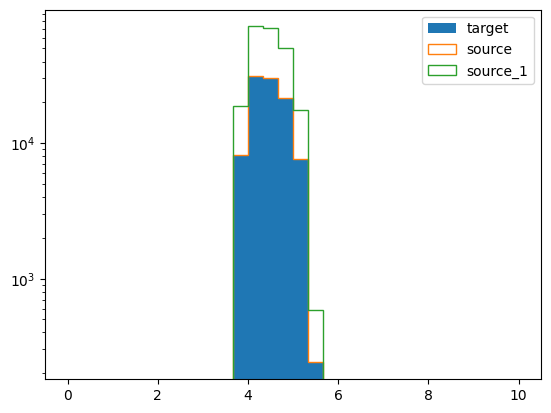

torch.Size([231000, 2])
torch.Size([99000, 2])
(99000, 2)


In [60]:


train, test_source = train_test_split(data, test_size=0.3)

log.info(f"Training size: {train.shape}")
log.info(f"Test size: {test_source.shape}")

# dataloaders
source_loader = loaders.Dataset(train,
                                nr_convex_dimensions=config['cvx_dim'],
                                nr_nonconvex_dimensions=config['noncvx_dim'],
                                batch_size=config['train_args']['batch_size'],
                                device=config['device'])

#return uniform distribution between 0,1 if cvx=1
base_distribution = loaders.get_base_distribution(config['cvx_dim'],
                                                    config['target_distribution'],
                                                    logit=False, 
                                                    device=config['device'])

target_loader = loaders.BaseDistribution(base_distribution,
                                        device = config['device'],
                                        batch_size=config['train_args']['batch_size'],
                                        dims=config['cvx_dim']
                                        )

target_loader.sample(test_source[:,:config['cvx_dim']])
test_source_1 = source_loader.data.clone()
test_target=target_loader.data.clone()

import matplotlib.pyplot as plt
plt.hist(test_target.detach().numpy()[:,0], bins=30, range=(0,10), label='target')
plt.hist(test_source.detach().numpy()[:,0], bins=30,histtype='step', range=(0,10), label='source')
plt.hist(test_source_1.detach().numpy()[:,0], bins=30,histtype='step', range=(0,10), label='source_1')
plt.legend()
plt.yscale('log')
plt.show()

print(test_source_1.shape)
print(test_source.shape)

print(test_target.detach().numpy().shape)